## Train model for binary MNIST
**Function        : Train model in pytorch for binary MNIST **<br>
**Author          : Team DIANNA **<br>
**Contributor     : **<br>
**First Built     : 2021.06.06 **<br>
**Last Update     : 2021.06.26 **<br>
**Library         : os, numpy, matplotlib, torch, tensorflow, wandb **<br>
**Description     : In this notebook we train models in pytorch for binary MNIST dataset. The trained models will be used to explore the XAI methods later.**<br>
**Return Values   : pytorch models and training status (.pt) / training report from weights & biases**<br>
**Note**          : The best trained model is stored as ONNX. For more information about how to load an ONNX model in pytorch, visit: https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html <br>

In [1]:
%matplotlib inline
import os
import time as tt
import numpy as np
# DL framework
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.onnx
# for plotting
import matplotlib.pyplot as plt
# report and monitoring with Weights & Biases
import wandb

In [2]:
#################################################################################
#########                     path to the dataset                        ########
#################################################################################
# please specify data path
datapath = '/mnt/d/NLeSC/DIANNA/data/mnist/binary-MNIST'
# please specify output path
output_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/example_data/model_generation/MNIST'
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok = True)

In [3]:
#################################################################################
#########              extract binary MNIST dataset locally              ########
#################################################################################
# load binary MNIST from local
# load data
fd = np.load(os.path.join(datapath, 'binary-mnist.npz'))
# training set
train_X = fd['X_train']
train_y = fd['y_train']
# testing set
test_X = fd['X_test']
test_y = fd['y_test']
fd.close()

# dimensions of data
print("dimensions of mnist:")
print("dimensions or training set", train_X.shape)
print("dimensions or training set label", train_y.shape)
print("dimensions or testing set", test_X.shape)
print("dimensions or testing set label", test_y.shape)
# statistics of training set
print("statistics of training set:")
print("Digits: 0 1")
print("labels: {}".format(np.unique(train_y)))
print("Class distribution: {}".format(np.bincount(train_y)))
print("Labels of training set", train_y[:20])

dimensions of mnist:
dimensions or training set (12665, 784)
dimensions or training set label (12665,)
dimensions or testing set (2115, 784)
dimensions or testing set label (2115,)
statistics of training set:
Digits: 0 1
labels: [0 1]
Class distribution: [5923 6742]
Labels of training set [0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1]


In [4]:
#################################################################################
#########              set up the environment for training               ########
#################################################################################
print ('*******************  check the version of pytorch  *********************')
print ("Pytorch version {}".format(torch.__version__))
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))
print ('*******************  login weights & biases  *********************')
# call weights & biases service
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
*******************  check the version of pytorch  *********************
Pytorch version 1.8.1
Is CUDA available? False
Device to be used for computation: cpu
*******************  login weights & biases  *********************
wandb: Currently logged in as: git-yang (use `wandb login --relogin` to force relogin)


True

In [6]:
#################################################################################
#########                      build neural network                      ########
#################################################################################
class MnistNet(nn.Module):
    def __init__(self, kernels=[16, 32], dropout = 0.1, classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(MnistNet, self).__init__()
        self.kernels = kernels
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Dropout()
        )
        self.fc1 = nn.Linear(7 * 7 * kernels[-1], kernels[-1]) # pixel 28 / maxpooling 2 * 2 = 7
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [7]:
#################################################################################
#########            configure hyper-parameters & prepare data           ########
#################################################################################
hyperparameters = dict(
    epoch = 10,
    classes = 2,
    kernels = [16, 32],
    batch_size = 64,
    learning_rate = 0.001,
    dropout = 0.5,
    dataset = 'MNIST',
    architecture = 'CNN'
)

# initialize weights & biases service
#mode = 'online'
mode = 'disabled'
wandb.init(config=hyperparameters, project='mnist', entity='dianna-ai', mode=mode)
config = wandb.config

# use pytorch data loader
train_X_torch = torch.from_numpy(train_X).type(torch.FloatTensor)
train_y_torch = torch.from_numpy(train_y).type(torch.LongTensor)

test_X_torch = torch.from_numpy(test_X).type(torch.FloatTensor)
test_y_torch = torch.from_numpy(test_y).type(torch.LongTensor)

# reshape the input following the definition in pytorch (batch, channel, Height, Width)
train_X_torch = train_X_torch.view(-1,1,28,28)
test_X_torch = test_X_torch.view(-1,1,28,28)

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch,train_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch,test_y_torch)

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)


In [8]:
#################################################################################
#########               create model and choose optimizer                ########
#################################################################################
model = MnistNet(config.kernels, config.dropout, config.classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss() # same as BCELoss(torch.sigmoid(x),...), but more numerically stable
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)

wandb.watch(model)

Model details:
 MnistNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=1568, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [9]:
#################################################################################
#########                   start the training process                   ########
#################################################################################
# calculate the time for the code execution
start_time = tt.time()
# switch model into train mode
model.train()
for epoch in range(config.epoch):
    # number of correction predictions
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        output = model(var_X_batch).squeeze(1)
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()
        # Total correct predictions
        predicted = torch.max(output.data, 1)[1]
        #predicted = torch.round(torch.sigmoid(output))
        correct += (predicted == var_y_batch).sum()
        # log the training loss and accuracy in wandb
        wandb.log({'train_loss': loss.item(), 'train_acc': float(correct*100) / float(config.batch_size*(batch_idx+1))})
        if batch_idx % 20 == 0:
            print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                  epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.* batch_idx / len(train_loader),
                  loss.item(), float(correct*100) / float(config.batch_size*(batch_idx+1))))

# save the general checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, os.path.join(output_path,'mnistnet_training_checkpoint.pt'))
print("The checkpoint of the model and training status is saved.")

print ("--- %s minutes ---" % ((tt.time() - start_time)/60))

Epoch : 0 [0/12665 (0%)]	Loss: 8.398658	 Accuracy:51.562%
Epoch : 0 [1280/12665 (10%)]	Loss: 0.054485	 Accuracy:92.783%
Epoch : 0 [2560/12665 (20%)]	Loss: 0.000000	 Accuracy:95.770%
Epoch : 0 [3840/12665 (30%)]	Loss: 0.000000	 Accuracy:96.952%
Epoch : 0 [5120/12665 (40%)]	Loss: 0.000000	 Accuracy:97.589%
Epoch : 0 [6400/12665 (51%)]	Loss: 0.089167	 Accuracy:97.912%
Epoch : 0 [7680/12665 (61%)]	Loss: 0.000000	 Accuracy:98.166%
Epoch : 0 [8960/12665 (71%)]	Loss: 0.000000	 Accuracy:98.349%
Epoch : 0 [10240/12665 (81%)]	Loss: 0.013582	 Accuracy:98.535%
Epoch : 0 [11520/12665 (91%)]	Loss: 0.000000	 Accuracy:98.679%
Epoch : 1 [0/12665 (0%)]	Loss: 0.380646	 Accuracy:98.438%
Epoch : 1 [1280/12665 (10%)]	Loss: 0.000000	 Accuracy:99.479%
Epoch : 1 [2560/12665 (20%)]	Loss: 0.000000	 Accuracy:99.543%
Epoch : 1 [3840/12665 (30%)]	Loss: 0.008374	 Accuracy:99.616%
Epoch : 1 [5120/12665 (40%)]	Loss: 0.000000	 Accuracy:99.614%
Epoch : 1 [6400/12665 (51%)]	Loss: 0.000000	 Accuracy:99.613%
Epoch : 1 [768

In [10]:
#################################################################################
#########                  start the evaluation process                  ########
#################################################################################
# switch model into evaluation mode
model.eval()
correct = 0
for batch_idx, (test_imgs, test_labels) in enumerate(test_loader):
    test_imgs = torch.autograd.Variable(test_imgs).float()
    output = model(test_imgs)
    predicted = torch.max(output,1)[1]
    correct += (predicted == test_labels).sum()
    wandb.log({'test_acc': float(correct*100) / float(config.batch_size*(batch_idx+1))})
    if batch_idx % 5 == 0:
        print("Test accuracy:{:.3f}% ".format(float(correct*100) / float(config.batch_size*(batch_idx+1))))
    


Test accuracy:100.000% 
Test accuracy:100.000% 
Test accuracy:100.000% 
Test accuracy:100.000% 
Test accuracy:100.000% 
Test accuracy:99.940% 
Test accuracy:99.899% 


Predictions: [1 0 1]
Ground Truth: tensor([1, 0, 1])


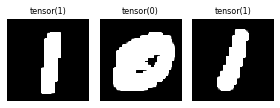

In [11]:
#################################################################################
#########                  check the evaluation results                  ########
#################################################################################
print("Predictions:", predicted[:3].detach().numpy())
print("Ground Truth:", test_labels[:3])
evaluate_fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4, 4))
axes = axes.flatten()

for i in range(3):
    a = axes[i]
    a.imshow(test_imgs[i,0,:,:], cmap='gray', vmin=0, vmax=1)
    a.set_title(test_labels[i], fontsize=8)
    a.axis('off')
    
evaluate_fig.tight_layout()

In [12]:
#################################################################################
#########                     save the model as ONNX                     ########
#################################################################################
# store as ONNX
# example input
x = next(iter(train_loader))[0]
torch.onnx.export(model, x, os.path.join(output_path,'mnist_model.onnx'), opset_version=11,
                  export_params=True, input_names=['input'], output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'},
                                'output': {0: 'batch_size'}})